In [10]:
import os
import editdistance
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
DATASET_PATH = os.path.join('morse_dataset', 'morse_dataset')
PREPROCESS = False 
TRAIN = True
DEBUG = True

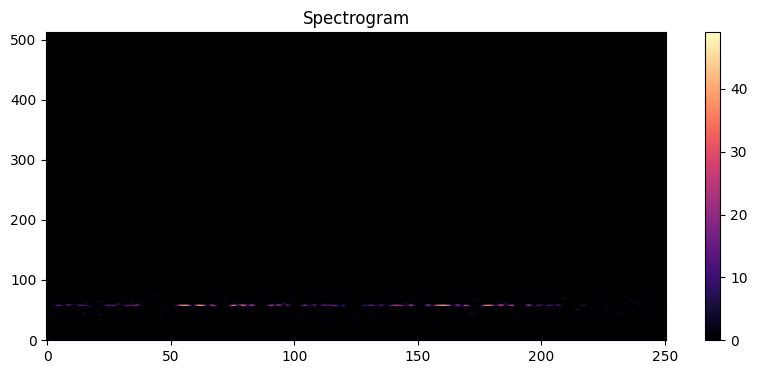

In [12]:
from morse import MorsePreprocessing

waveform, sample_rate = torchaudio.load(os.path.join(DATASET_PATH, '21600.opus'))

transform = MorsePreprocessing()
spec = transform(waveform)

plt.figure(figsize=(10, 4))
plt.imshow(spec[0,:,:].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

In [13]:
from preprocessing import preprocess_dataset

df = pd.read_csv('train.csv')
labels_dict = {
        f"{row['id']}": row['message']
        for _, row in df.iterrows()
    }

if PREPROCESS:
    preprocess_dataset(DATASET_PATH, "data_preprocessed", labels_dict, transform)

In [14]:
from preprocessing import PreprocessedDataset

c2i = {
    '<blank>': 0,
    '.': 1,
    '-': 2,
    ' ': 3,
    '/': 4
}
i2c = {v: k for k, v in c2i.items()}

train_dataset = PreprocessedDataset('data_preprocessed/train', c2i)
val_dataset = PreprocessedDataset('data_preprocessed/val', c2i)

In [15]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, targets, input_lengths, target_lengths = zip(*batch)

    features = [f.transpose(0, 1) for f in features]

    padded_features = pad_sequence(features, batch_first=True)
    padded_targets = torch.cat(targets)

    input_lengths = torch.tensor([f.shape[0] for f in features], dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return padded_features, padded_targets, input_lengths, target_lengths

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

In [17]:
from morse import MorseConformer

model = MorseConformer(
    input_dim=513,
    output_dim=5,
).to('cuda')

In [18]:
from train import train
from train import cross_val_scores

if DEBUG:
    scores = cross_val_scores(model, train_dataset, train, collate_fn, num_epochs=100, patience=5)
    
    print(f'Scores: {scores}')
    print(f'Mean: {np.mean(scores)}')
    print(f'Std: {np.std(scores)}')

Scores: [-0.040991630684584376, -0.04299987945705652, -0.03939034249633551, -0.045070447586476804, -0.042568163853138684]
Mean: -0.04220409281551838
Std: 0.0019167195439047065


In [19]:
if TRAIN:
    train(model=model, train_loader=train_loader, val_loader=val_loader, num_epochs=100, patience=5, log=True)

model.load_state_dict(torch.load('models/best_model.pt', map_location='cuda'))

[Epoch 1] train loss: 2.5759 | val loss: 1.2007


[Epoch 2] train loss: 1.1858 | val loss: 1.1882


[Epoch 3] train loss: 1.1699 | val loss: 1.1794


[Epoch 4] train loss: 1.1184 | val loss: 0.9327


[Epoch 5] train loss: 0.3462 | val loss: 0.1043


[Epoch 6] train loss: 0.0897 | val loss: 0.0720


[Epoch 7] train loss: 0.0641 | val loss: 0.0545


[Epoch 8] train loss: 0.0536 | val loss: 0.0495


[Epoch 9] train loss: 0.0471 | val loss: 0.0478


[Epoch 10] train loss: 0.0430 | val loss: 0.0417


[Epoch 11] train loss: 0.0393 | val loss: 0.0403


[Epoch 12] train loss: 0.0364 | val loss: 0.0391


[Epoch 13] train loss: 0.0343 | val loss: 0.0376


[Epoch 14] train loss: 0.0325 | val loss: 0.0381


[Epoch 15] train loss: 0.0303 | val loss: 0.0369


[Epoch 16] train loss: 0.0292 | val loss: 0.0360


[Epoch 17] train loss: 0.0278 | val loss: 0.0372


[Epoch 18] train loss: 0.0267 | val loss: 0.0365


[Epoch 19] train loss: 0.0259 | val loss: 0.0354


[Epoch 20] train loss: 0.0246 | val loss: 0.0352


[Epoch 21] train loss: 0.0232 | val loss: 0.0352


[Epoch 22] train loss: 0.0227 | val loss: 0.0357


[Epoch 23] train loss: 0.0216 | val loss: 0.0347


[Epoch 24] train loss: 0.0213 | val loss: 0.0358


[Epoch 25] train loss: 0.0209 | val loss: 0.0351


[Epoch 26] train loss: 0.0198 | val loss: 0.0347


[Epoch 27] train loss: 0.0189 | val loss: 0.0367


[Epoch 28] train loss: 0.0185 | val loss: 0.0355


<All keys matched successfully>

In [20]:
from torchaudio.models.decoder import ctc_decoder

labels = list(c2i.keys())
decoder = ctc_decoder(
    lexicon=None,
    tokens=labels,
    beam_size=10,
    blank_token='<blank>',
    unk_word='<blank>',
    sil_token='<blank>'
)

In [21]:
from preprocessing import preprocess_audio
from preprocessing import decode_from_morse
from torch.nn.functional import log_softmax

def submit():
    model.eval()
    submission = []
    
    target_files = sorted([
        f for f in os.listdir(DATASET_PATH)
        if f.endswith('.opus') and 30001 <= int(os.path.splitext(f)[0]) <= 35000
    ], key=lambda x: int(os.path.splitext(x)[0]))
    
    with torch.no_grad():
        for fname in target_files:
            path = os.path.join(DATASET_PATH, fname)
            mel = preprocess_audio(path, transform)
            mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
            input_len = torch.tensor([mel.shape[1]], device='cuda')
    
            logits = model(mel)
            log_probs = log_softmax(logits, dim=-1)
            log_probs_btc = log_probs.transpose(0, 1)
            
            decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
            decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
            decoded_text = decode_from_morse(decoded_morse)
    
            submission.append({
                "id": fname,
                "message": decoded_text
            })
    
    df = pd.DataFrame(submission)
    df.to_csv("submission.csv", index=False)

submit()

In [22]:
from torch.nn.functional import log_softmax
from torch.nn import CTCLoss

model.eval()
ctc_loss_fn = CTCLoss(blank=0, zero_infinity=True)
val_losses = []
levenshtein_scores = []

with torch.no_grad():
    for features, targets, input_lengths, target_lengths in val_loader:
        features = features.to('cuda')
        targets = targets.to('cuda')
        input_lengths = input_lengths.to('cuda')
        target_lengths = target_lengths.to('cuda')
        
        log_probs = model(features, input_lengths)
        log_probs = log_softmax(log_probs, dim=-1)
        
        loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)
        val_losses.append(loss.item())
        
        log_probs_btc = log_probs.transpose(0, 1)
        
        decoded_output = decoder(log_probs_btc.cpu().contiguous(), input_lengths.cpu())
        decoded_batch = [''.join([labels[token.item()] for token in hypo[0].tokens]) for hypo in decoded_output]
        target_batch = []
        start = 0
        
        for length in target_lengths:
            length = int(length)
            target_seq = targets[start:start + length]
            text = ''.join([i2c[int(c)] for c in target_seq])
            target_batch.append(text)
            start += length
        
        for pred, true in zip(decoded_batch, target_batch):
            dist = editdistance.eval(decode_from_morse(pred), decode_from_morse(true))
            levenshtein_scores.append(dist)

mean_val_loss = sum(val_losses) / len(val_loader)
mean_levenshtein = sum(levenshtein_scores) / len(levenshtein_scores)

print(f"Val CTC Loss: {mean_val_loss:.4f}")
print(f"Mean Levenshtein: {mean_levenshtein:.4f}")

Val CTC Loss: 0.0349
Mean Levenshtein: 0.3782


In [24]:
total_files = 35000
sr = 8000
duration_sec = 11
max_samples = sr * duration_sec

for file in range(total_files - 16, total_files + 1):
    path = os.path.join(DATASET_PATH, f'{file}.opus')

    waveform, sample_rate = torchaudio.load(path)
    waveform = waveform[:, :max_samples]

    mel = transform(waveform).squeeze(0)
    mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
    input_len = torch.tensor([mel.shape[1]], device='cuda')

    logits = model(mel)
    log_probs = log_softmax(logits, dim=-1)
    log_probs_btc = log_probs.transpose(0, 1)

    decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
    decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
    decoded_text = decode_from_morse(decoded_morse)

    print(f"{file}.opus,{decoded_text}")

34984.opus,ДАМАМНОТИРСЫ УМЦ
34985.opus,? ЬСВЕД?ЧВНТИ ЯМ?Ы
34986.opus,АНХ ВСОЕГЬ Р ВКТДАМИРК
34987.opus,ИЛ ДАСДП ЬСОЕМУНТИ ИГА
34988.opus,УЬТКП ДСЯНКМЫОЦ ИМК
34989.opus,КНОЬКМ СОФЫМОП ЬС?
34990.opus,ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙТ
34991.opus,ИЛ ДАСДП ОСЮВНЫМ НЮ
34992.opus,АС АТ ИСЧТИ КГЖБПГ
34993.opus,2?Л МЫЛИМЕТ Т
34994.opus,АН ЖНОЕСУ ЬТКТВНЖМ М
34995.opus,ОДЦЮП ЬСВВТКЧМД?О
34996.opus,ОРСКС ИЛ ДАСДП ЬСОЕМИ
34997.opus,ОИСЧТИ СЕЬК?ЗП ЮН ДН
34998.opus,ТОЫМ ДЛ ЬСЧТЫНТ
34999.opus,ОДТЕ ?ЫАЯН МНКМЕ М
35000.opus,Л?Я ЬТКТВНЖМ
